# Algoritmos de detección de anomalías: Distribución Gaussiana

A partir del conjunto de datos de transacciones bancarias legitimas o ilegitimas, entrenar un modelo basado en el algoritmo de distribucion gaussiana que modele las transaciones etiquetadas como **legitimas** y todas aquellas que salgan de ese rango serán consideradas automaticamente como **ilegitimas**. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec
from collections import Counter
from sklearn import metrics
import numpy as np
from matplotlib.colors import LogNorm
from sklearn.metrics import f1_score

## 1. Leer el conjunto de datos

In [2]:
df = pd.read_csv("../datasets/creditcard.csv")

## 2. Visualización de la data

In [3]:
df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [5]:
df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

En este tipo de conjuntos desesquilibrados es donde podemos hallar el uso significativo de este tipo de algoritmos

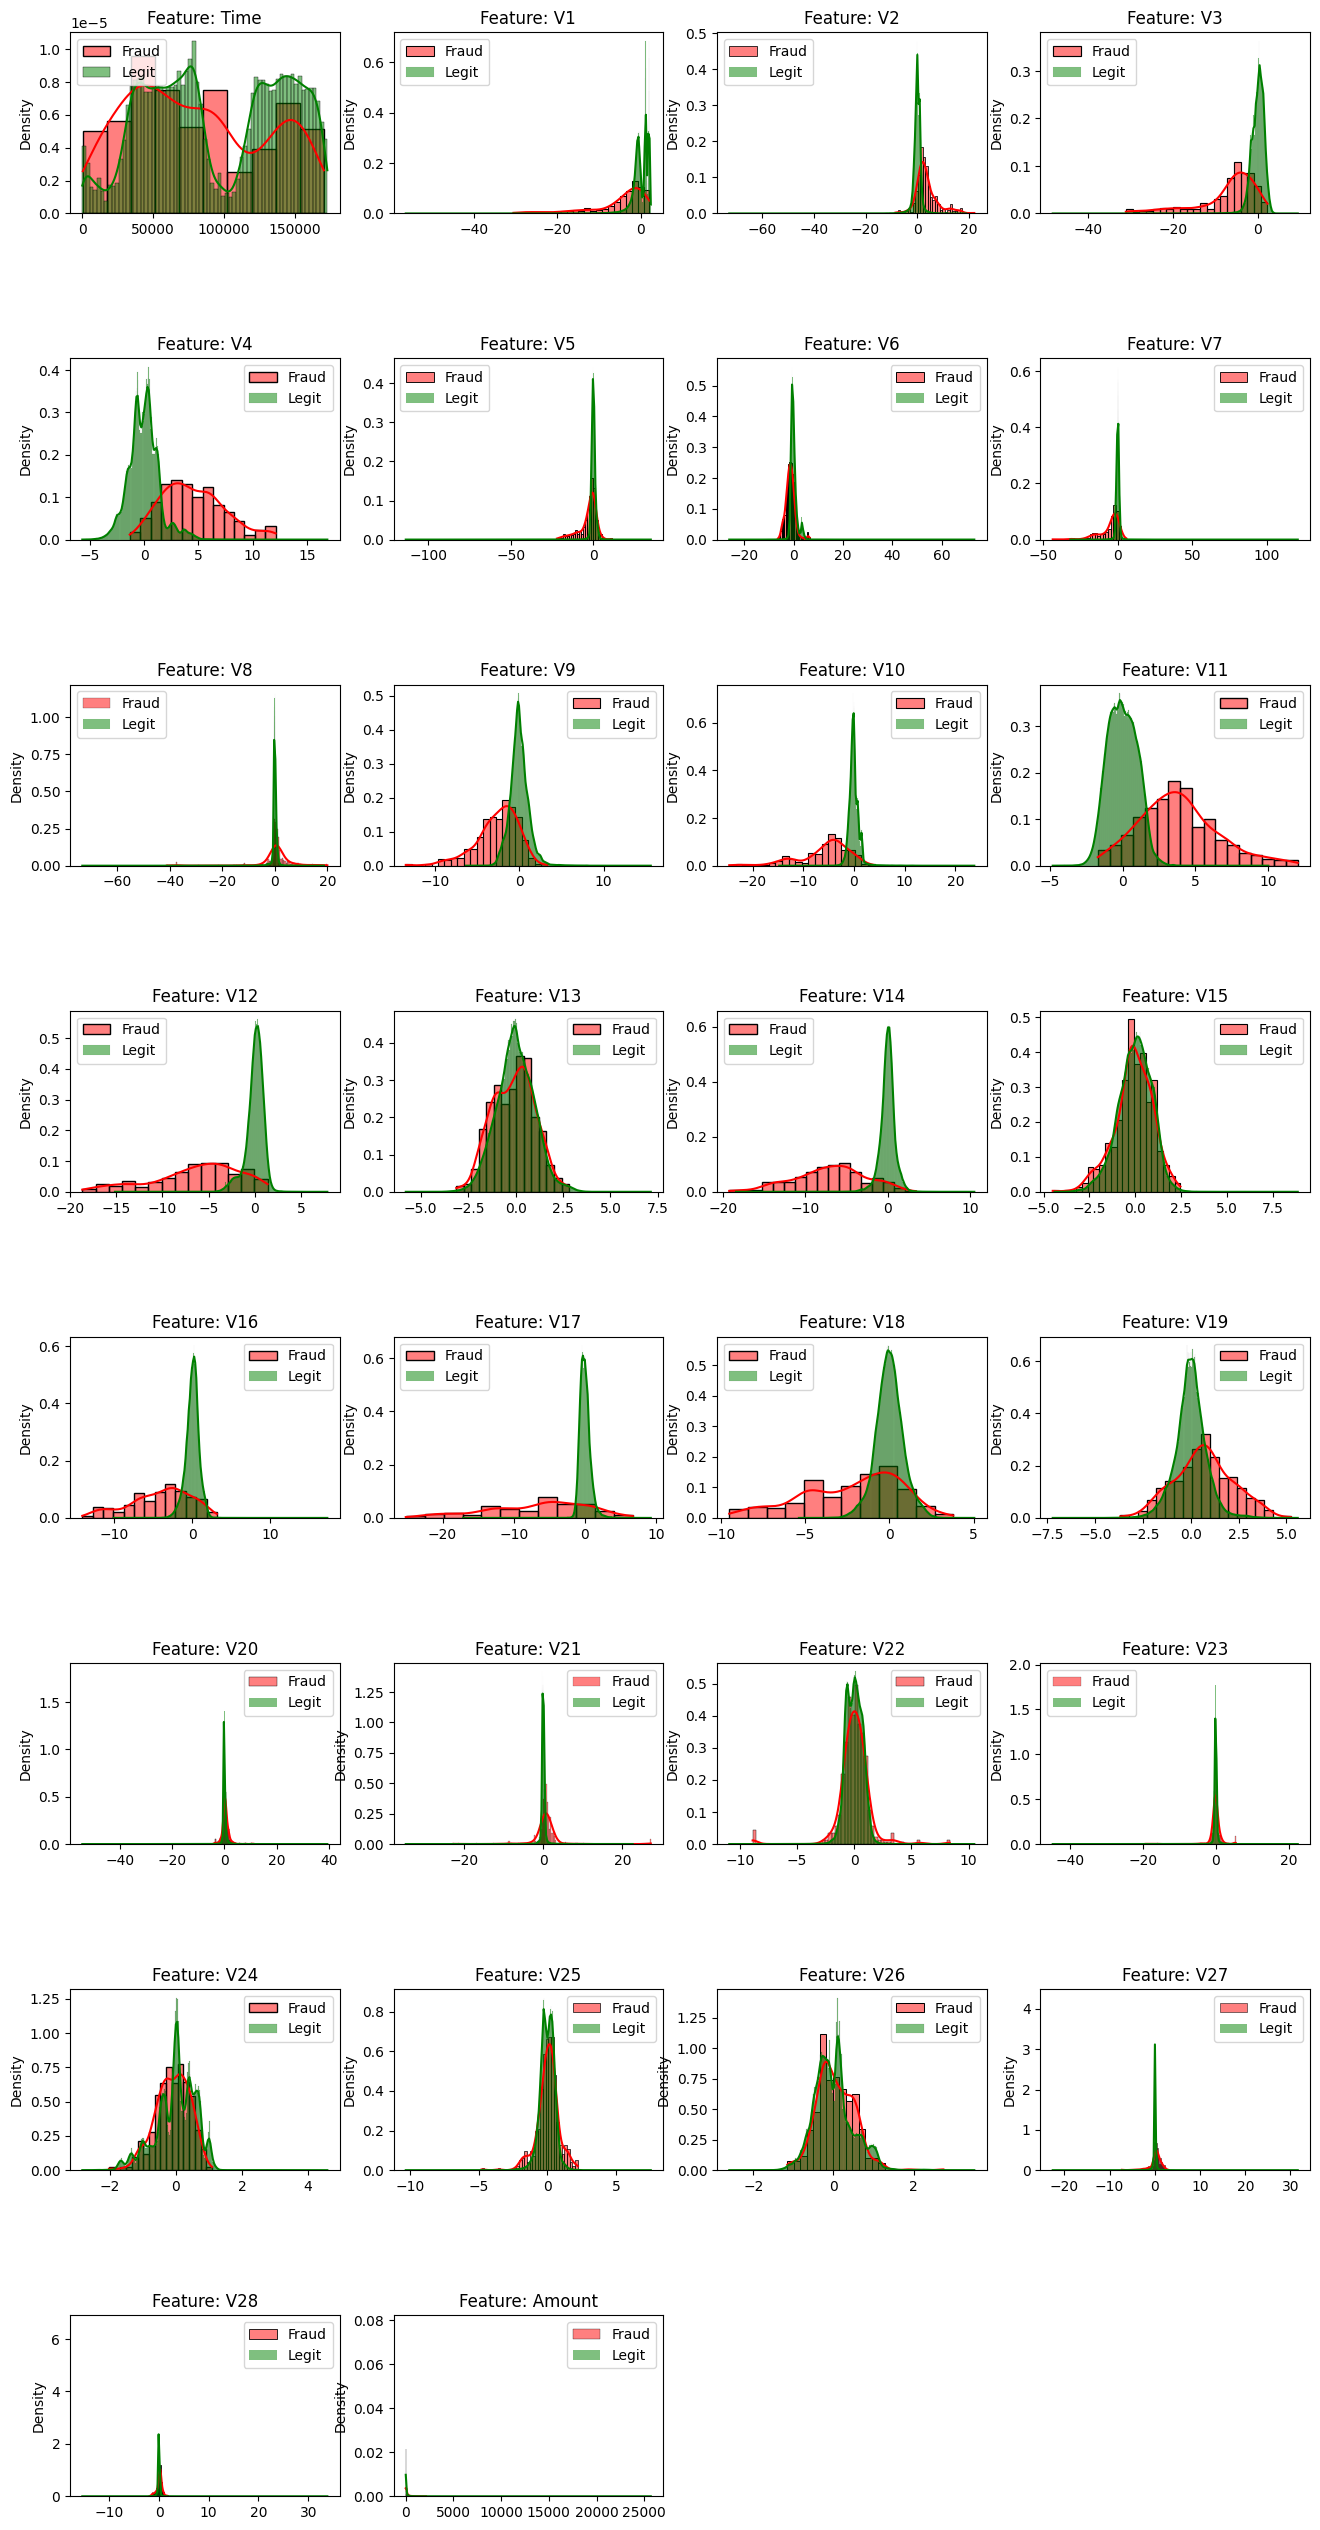

In [6]:
# Representamos gráficamente las características
features = df.drop("Class", axis=1)

plt.figure(figsize=(16, 32))
gs = gridspec.GridSpec(8, 4)
gs.update(hspace=0.8)

for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    # Usando histplot para los casos donde Class == 1
    sns.histplot(data=df[df["Class"] == 1], x=f, kde=True, color="red", stat="density", label="Fraud", alpha=0.5)
    # Usando histplot para los casos donde Class == 0
    sns.histplot(data=df[df["Class"] == 0], x=f, kde=True, color="green", stat="density", label="Legit", alpha=0.5)
    ax.set_xlabel('')
    ax.set_title(f"Feature: {f}")
    ax.legend()

plt.show()

Con esta grafica de densidad podemos darnos cuenta de que caracteristicas diferencian mejor los valores legitimos de los no legitimos y cuales no lo hacen, asi podemos ir nos dando cuenta de que caracteristicas pueden ser mas relevantes para nuestro modelo

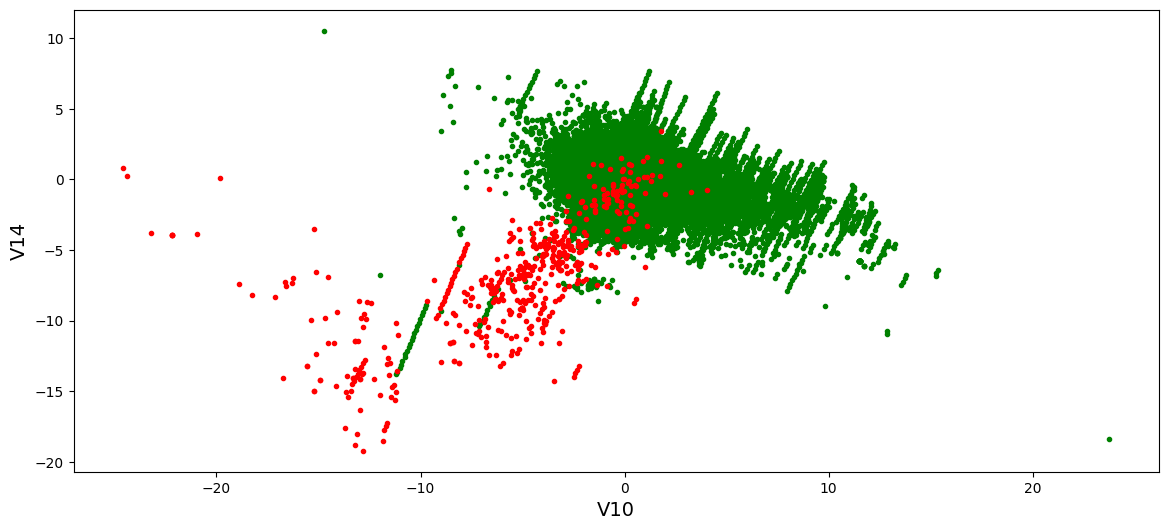

In [7]:
# Representación gráfica de dos características que si diferencian los valores 
# legitimos de los ilegitimos
plt.figure(figsize=(14, 6))
plt.scatter(df["V10"][df['Class'] == 0], df["V14"][df['Class'] == 0], c="g", marker=".")
plt.scatter(df["V10"][df['Class'] == 1], df["V14"][df['Class'] == 1], c="r", marker=".")
plt.xlabel("V10", fontsize=14)
plt.ylabel("V14", fontsize=14)
plt.show()

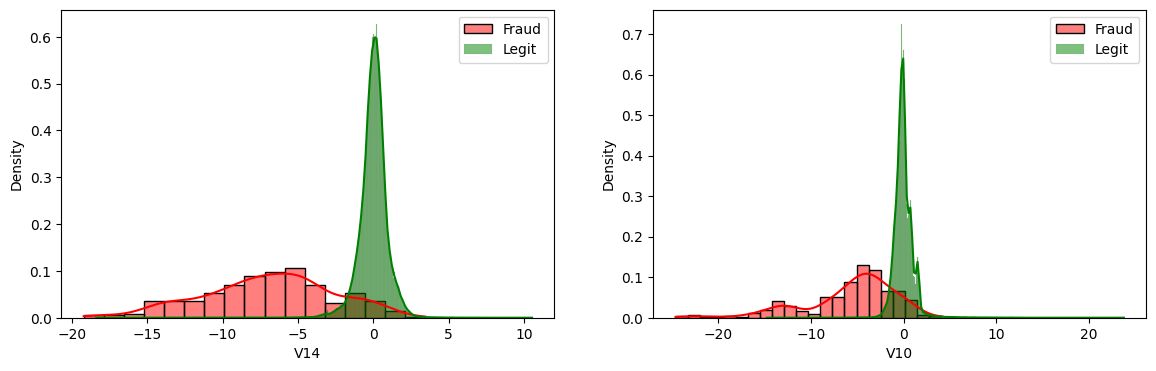

In [8]:
plt.figure(figsize=(14,4))
gs = gridspec.GridSpec(1, 2)

# Representación de la característica 1
ax = plt.subplot(gs[0])
sns.histplot(data=df[df['Class'] == 1], x="V14", kde=True, color="red", stat="density", label="Fraud", alpha=0.5)
sns.histplot(data=df[df['Class'] == 0], x="V14", kde=True, color="green", stat="density", label="Legit", alpha=0.5)
ax.legend()  # Para mostrar la leyenda

# Representación de la característica 2
ax = plt.subplot(gs[1])
sns.histplot(data=df[df['Class'] == 1], x="V10", kde=True, color="red", stat="density", label="Fraud", alpha=0.5)
sns.histplot(data=df[df['Class'] == 0], x="V10", kde=True, color="green", stat="density", label="Legit", alpha=0.5)
ax.legend()  # Para mostrar la leyenda

plt.show()

## 3. Preparar el conjunto de datos

Para este tipo de algoritmos es importante que todos los datos se encuentren en un rango similar, por lo tanto, podemos aplicar una función de escalado o normalización. Otra opción, es eliminar las características que no se encuentran en un rango similar siempre y cuando no sean muy influyentes para la predicción.

In [9]:
# En este caso vamos a eliminar dos columnas que no aportan relevancia a la 
# de los valores
df_prep = df.drop(['Time', 'Amount'], axis=1)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


## 4. Distribucion Gaussiana con un conjunto en dos dimensiones

In [11]:
x = df_prep.drop('Class', axis=1)
y = df_prep['Class'].copy()

In [12]:
x_red = x[['V10', 'V14']].copy()

In [13]:
# Entrenamiento 
from sklearn.mixture import GaussianMixture

model_gausd = GaussianMixture(n_components=2, random_state=42)
model_gausd.fit(x_red) # No necesita que se le pase las etiquetas de salida

GaussianMixture(n_components=2, random_state=42)

In [14]:
# Representacion del limite de decision
def plot_gaussian_mixture(clusterer, X, y, resolution=1000):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'k.', markersize=2)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], 'r.', markersize=2)

/home/ljmor/anaconda3/envs/curso_deep_learning/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/home/ljmor/anaconda3/envs/curso_deep_learning/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(


<Figure size 1400x600 with 0 Axes>

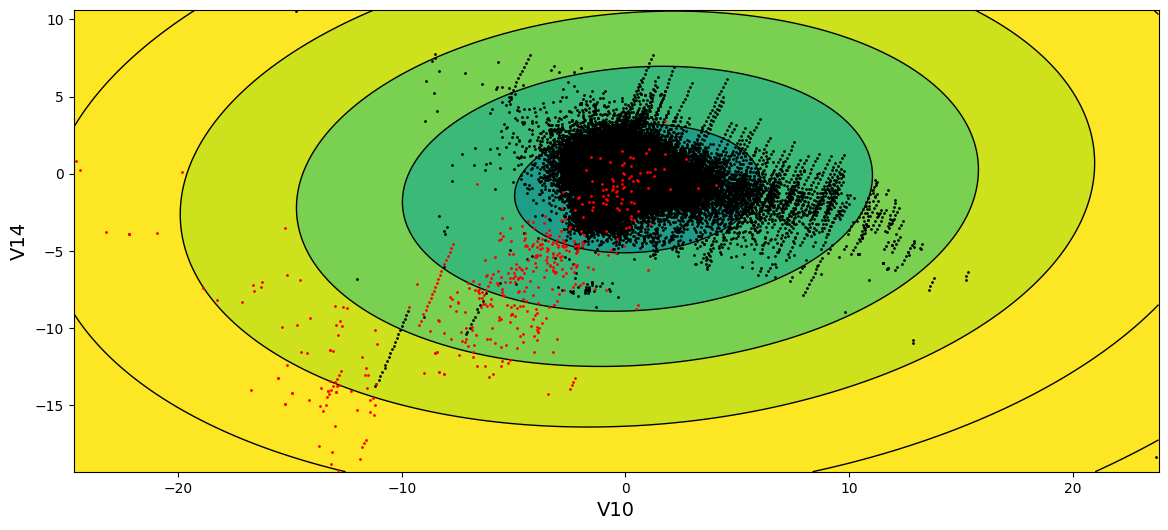

In [16]:
plt.figure(figsize=(14, 6))
plot_gaussian_mixture(model_gausd, x_red.values, y)
plt.xlabel("V10", fontsize=14)
plt.ylabel("V14", fontsize=14)
plt.show()

Podemos observar como los ejemplos anomalos sen encuantran en las zonas de menor densidad del modelo

### Identificar las anomalias

Para la identificación de las anomalías, se debe seleccionar un threshold a partir del cual, todos los ejemplos que se encuentren en regiones con una densidad menor a la indicada en el threshold, se consideran anomalías.

In [44]:
# Selección del Threshold
densities = model_gausd.score_samples(x_red)
density_threshold = np.percentile(densities, 0.15)
print("Threshold seleccionado:", density_threshold)

Threshold seleccionado: -12.746641944229635


In [45]:
# Identificación de anomalías
anomalies = x_red.values[densities < density_threshold]

/home/ljmor/anaconda3/envs/curso_deep_learning/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/home/ljmor/anaconda3/envs/curso_deep_learning/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(


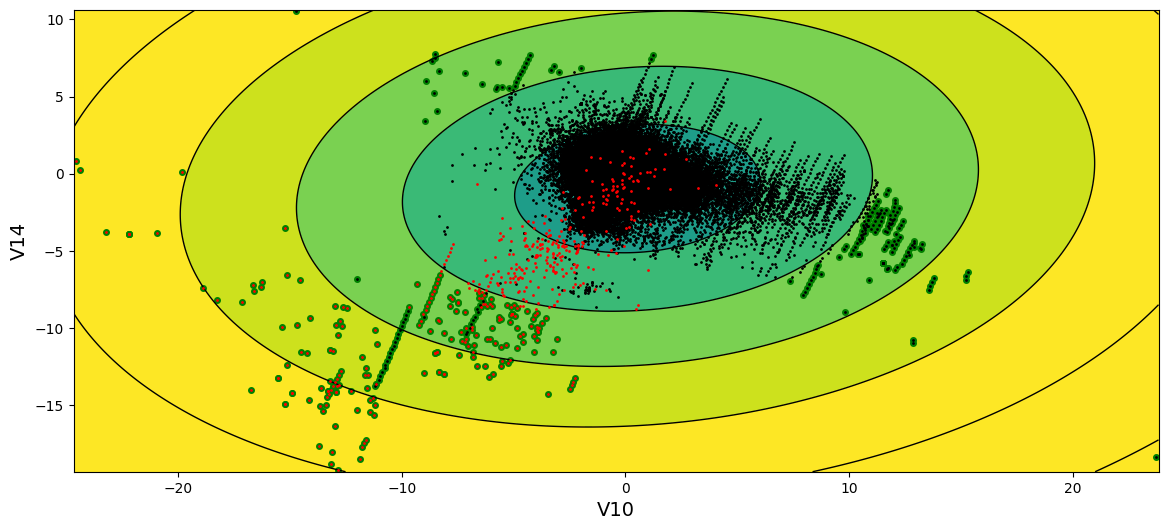

In [46]:
# Representación gráfica de las anomalías (Marcadas de color verde)
plt.figure(figsize=(14, 6))
plt.plot(anomalies[:, 0], anomalies[:, 1], 'go', markersize=4)
plot_gaussian_mixture(model_gausd, x_red.values, y)
plt.xlabel("V10", fontsize=14)
plt.ylabel("V14", fontsize=14)
plt.show()

In [47]:
# Comparación de cuantas anomalías se correspondían con ejemplos fraudulentos
y_preds = (densities < density_threshold)
y_preds[y_preds == False] = 0
y_preds[y_preds == True] = 1

In [48]:
# Clases originales
y.value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [49]:
# Casos identificados como anomalías etiquetados como negativos (0) y positivos (1)
y[y_preds==1].value_counts()

Class
0    224
1    204
Name: count, dtype: int64

Podemos ver como con ese treshold selecciono 204 de 492 ejemplos maliciosos y 224 de 284 315 ejemplos legitimos, este valor puede variar si cambiamos el treshold

## 5. Distribucion Gaussiana con un conjunto multidimensional

In [50]:
# Entrenar el modelo
from sklearn.mixture import GaussianMixture

model_gausd = GaussianMixture(n_components=2, random_state=42)
model_gausd.fit(x)

GaussianMixture(n_components=2, random_state=42)

In [51]:
# Selección del Threshold
densities = model_gausd.score_samples(x)
density_threshold = np.percentile(densities, 0.15)
print("Threshold seleccionado:", density_threshold)

Threshold seleccionado: -301.1624770118854


In [52]:
# Comparación de cuantas anomalías se correspondían con ejemplos fraudulentos
y_preds = (densities < density_threshold)
y_preds[y_preds == False] = 0
y_preds[y_preds == True] = 1

In [53]:
# Clases originales
y.value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [54]:
# Casos identificados como anomalías etiquetados como negativos (0) y positivos (1)
y[y_preds==1].value_counts()

Class
0    315
1    113
Name: count, dtype: int64

## 6. Busqueda del mejor Threshold

In [56]:
from sklearn.metrics import precision_score

def select_threshold(list_thds, densities, y):
    best_prec = 0
    best_threshold = 0
    i = 0
    for thd in list_thds:
        i += 1
        print("\rSearching best threshold {0}%".format(
            int((i + 1) / len(list_thds) * 100)), end='')
        preds = (densities < thd)
        preds[preds == False] = 0
        preds[preds == True] = 1
        precision = precision_score(y, preds)
        if precision > best_prec:
            best_prec = precision
            best_threshold = thd
    return (best_prec, best_threshold)

In [57]:
# Enviamos el rango de thresholds a usar, las densidades y la etiqueta
select_threshold(np.arange(-600, -300, 1), densities, y)

Searching best threshold 100%

(0.425531914893617, -470)

El threshold mas optimo sera -470